<a href="https://colab.research.google.com/github/kylebatucal/centaur-classifier/blob/main/centaur_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Centaur Image Classifier

This is the source code for my **SIGBOVIK 2024** paper which you can read here: https://github.com/kylebatucal/centaur-classifier/blob/main/sigbovik_2024.pdf

In this notebook, we will be fine-tuning a pre-trained model to determine if a centaur is more human or more horse using Tensorflow.



In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import models, layers, applications, utils

import numpy as np
import matplotlib.pyplot as plt

## Dataset

We will be using Laurence Moroney's *Horses or Humans* dataset to train our model. Luckily for us, it is a part of Tensorflow's dataset and is totally not the reason why I used Tensorflow for this project.

In [2]:
batch_size = 16 # this number was chosen arbitrarily

# Note: running this block will download some files to disk
(train_ds, test_ds), ds_info = tfds.load("horses_or_humans", split=["train", "test"], batch_size=batch_size, shuffle_files=True, as_supervised=True, with_info=True)

Let's take a look at some of the training images:

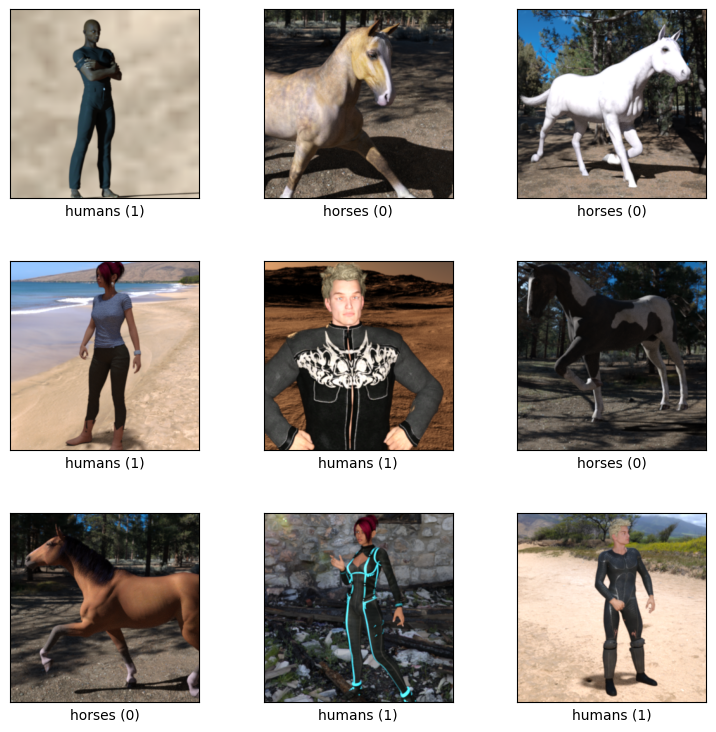

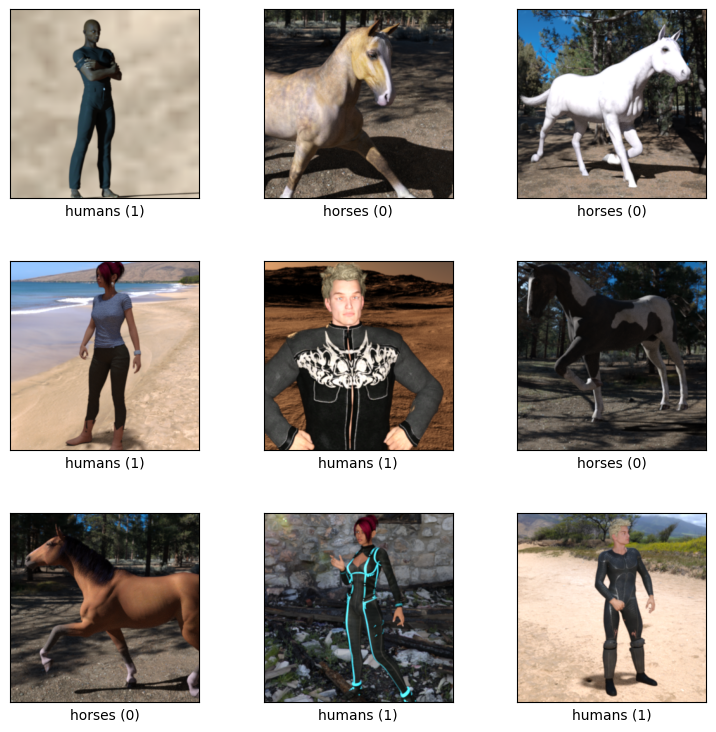

In [3]:
tfds.show_examples(train_ds, ds_info, is_batched=True)

As you can see, the dataset contains images of CGI-based humans and horses instead of real-life-based humans and horses. However, this won't affect our results.

## Training

We will be using EfficientNetV2-B0 as our base model. The reason I chose EfficientNetV2-B0 is because it is efficient.

I introduce some data augmentation layers and dropout to reduce overfitting.

In [4]:
base_model = applications.EfficientNetV2B0(include_top=False, pooling="avg", input_shape=(300, 300, 3), classes=2)
base_model.trainable = False

model = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    base_model,
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

24274472/24274472 [==============================] - 0s 0us/step


Since there are only two things we need to classify, we can just use 1 output neuron, with outputs close to 1 being "humans", and outputs close to 0 being "horses". The math is actually the same as using two outputs with the softmax function.

In [5]:
# Compile the model using most of the defaults
model.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
# Check how the model performs before training it
model.evaluate(test_ds)

16/16 [==============================] - 27s 1s/step - loss: 0.7182 - accuracy: 0.4297


[0.7181832790374756, 0.4296875]

In [7]:
# Train the model
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
65/65 [==============================] - 109s 2s/step - loss: 0.2206 - accuracy: 0.9611 - val_loss: 0.0611 - val_accuracy: 1.0000
Epoch 2/5
65/65 [==============================] - 91s 1s/step - loss: 0.0417 - accuracy: 0.9951 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 3/5
65/65 [==============================] - 94s 1s/step - loss: 0.0179 - accuracy: 0.9971 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 4/5
65/65 [==============================] - 86s 1s/step - loss: 0.0081 - accuracy: 0.9990 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 5/5
65/65 [==============================] - 86s 1s/step - loss: 0.0073 - accuracy: 0.9971 - val_loss: 0.0032 - val_accuracy: 1.0000


We actually achieve 100% training accuracy after the first epoch; however, for our use case, it is actually better it we reduce the loss as low as we can. I trained it for 4 more epochs and didn't see any signs of overfitting, so you could probably train it some more.

## Inference

To test how our model performs with real-life-based images, I sourced a very large dataset (8 images) of humans and horses from Unsplash, four for each.

In [16]:
# Helper function that displays the image and prints out the predicted score
def predict_image(filepath):
    image = utils.load_img(filepath, target_size=(300,300), keep_aspect_ratio=True)
    plt.imshow(image)
    plt.axis("off")

    image_arr = utils.img_to_array(image)
    image_arr = np.array([image_arr]) # convert to a batch
    predictions = model.predict(image_arr)
    score = predictions[0][0] # squeeze it out
    print(f"Horse score: {1-score:4f}")
    print(f"Human score: {score:4f}")
    return score

### Horses

In [17]:
horse_average = 0

1/1 [==============================] - 0s 112ms/step
Horse score: 0.999471
Human score: 0.000529


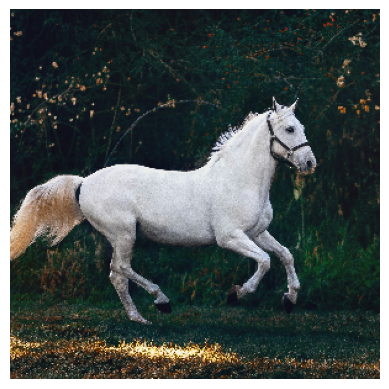

In [18]:
horse_average += predict_image("data/horses/horse1.jpg")

1/1 [==============================] - 0s 77ms/step
Horse score: 0.997849
Human score: 0.002151


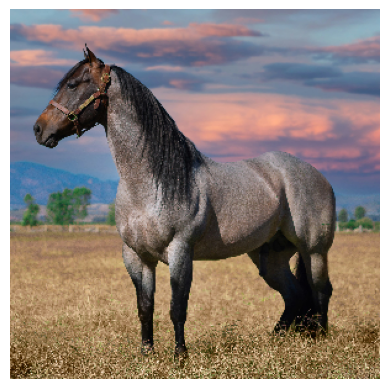

In [19]:
horse_average += predict_image("data/horses/horse2.jpg")

1/1 [==============================] - 0s 85ms/step
Horse score: 0.984869
Human score: 0.015131


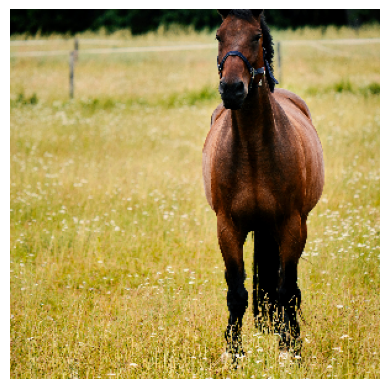

In [20]:
horse_average += predict_image("data/horses/horse3.jpg")

1/1 [==============================] - 0s 77ms/step
Horse score: 0.999472
Human score: 0.000528


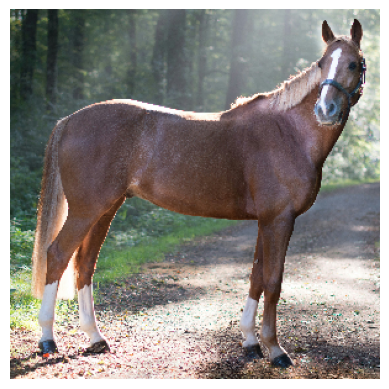

In [21]:
horse_average += predict_image("data/horses/horse4.jpg")

In [22]:
1-horse_average/4

0.995415381868952

As you can see, the model actually performs remarkably well with real-life images. The average score is 0.995, meaning horses are actually 99.5% horse, and 0.5% human.

### Humans

I searched for human images using the search term "person standing". This gave me photos of people posing in the same way as the training images.

In [23]:
human_average = 0

1/1 [==============================] - 0s 77ms/step
Horse score: 0.013131
Human score: 0.986869


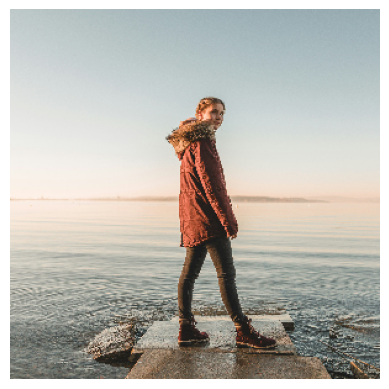

In [24]:
human_average += predict_image("data/humans/human1.jpg")

1/1 [==============================] - 0s 81ms/step
Horse score: 0.006941
Human score: 0.993059


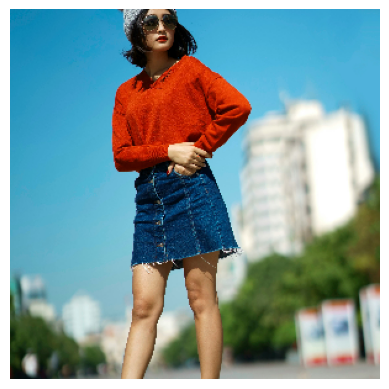

In [25]:
human_average += predict_image("data/humans/human2.jpg")

1/1 [==============================] - 0s 75ms/step
Horse score: 0.000352
Human score: 0.999648


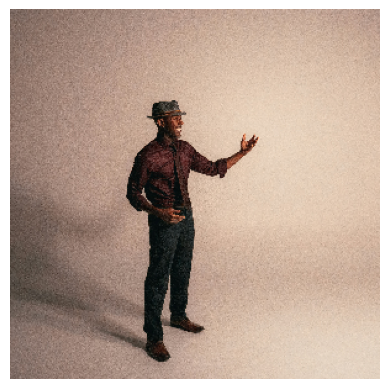

In [26]:
human_average += predict_image("data/humans/human3.jpg")

1/1 [==============================] - 0s 77ms/step
Horse score: 0.002017
Human score: 0.997983


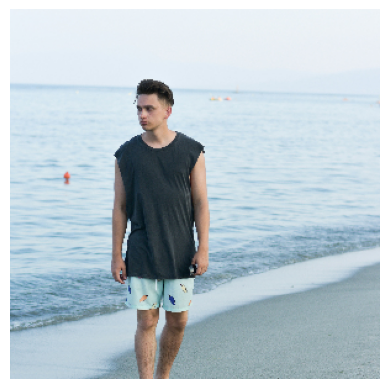

In [27]:
human_average += predict_image("data/humans/human4.jpg")

In [28]:
human_average/4

0.9943898916244507

Likewise, the model performs well for real-life images of humans. The average human score is 0.994, meaning that humans are actually 99.4% human, and 0.6% horse.

### Centaurs

Because there are no "real" photos of centaurs, I asked Meta AI to generate an image of a centaur. Below is what it gave me:

1/1 [==============================] - 0s 81ms/step
Horse score: 0.957266
Human score: 0.042734


0.042734142

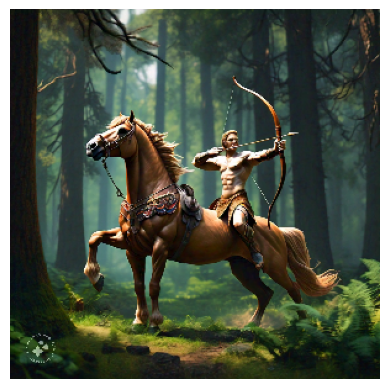

In [29]:
predict_image("data/centaurs/meta.jpg")

After rerunning the notebook this time around, the model says that the centaur is 2% more human than I said in the paper. Oh well. I suppose there is some variance to it. The conclusion still stands.

If you were actually curious to see how the model classifies other pictures of centaurs, it's pretty similar. The model thinks it is looking at a horse.

1/1 [==============================] - 0s 74ms/step
Horse score: 0.994872
Human score: 0.005128


0.0051278365

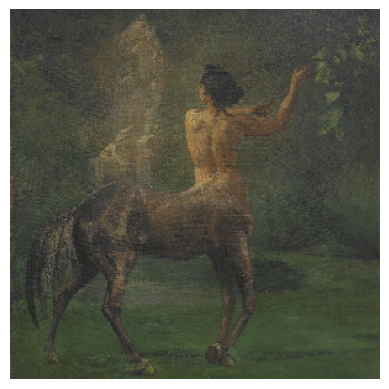

In [30]:
predict_image("data/centaurs/centauress.jpg")

1/1 [==============================] - 0s 80ms/step
Horse score: 0.991268
Human score: 0.008732


0.008732106

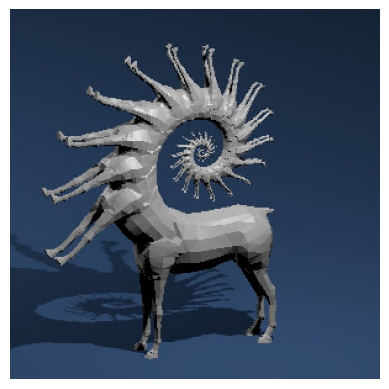

In [31]:
predict_image("data/centaurs/recursive_horse.jpg")

1/1 [==============================] - 0s 143ms/step
Horse score: 0.981663
Human score: 0.018337


0.01833721

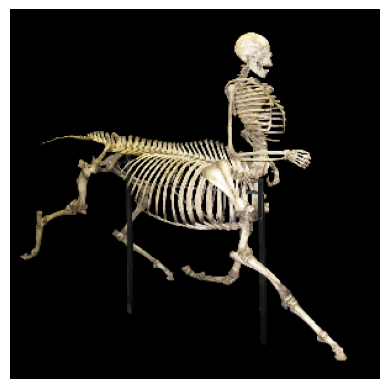

In [32]:
predict_image("data/centaurs/skellybones.jpg")